# Example of loading MT Stations

In [1]:
# For updating bezpy without needing to restart the entire kernel
%load_ext autoreload
%autoreload 2

import glob
# NOTE: Must load Basemap before geopandas...
from mpl_toolkits.basemap import Basemap

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

import bezpy

## Set up the area of interest

In [2]:
frd_lat = 38.205
frd_lon = -77.373
lat_bounds = [frd_lat-3, frd_lat+3]
lon_bounds = [frd_lon-3, frd_lon+3]

## Set up the paths to all the data

In [3]:
MT_data_folder = "/Users/glucas/work/data/MT_sites/"
# Get all sub folders downloaded from the USArray website
xml_files = sorted(glob.glob(MT_data_folder + "MT_TF_*/*.xml"))

There are 73 MT sites


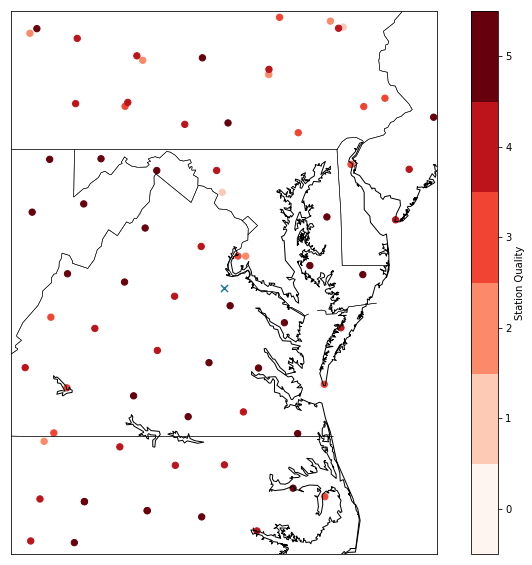

In [4]:
MT_sites = {}
MT_xy_locs = []
ratings = []

for fname in xml_files:
    
    # Reads in an IRIS XML file and returns a Site object
    site = bezpy.mt.read_xml(fname)
    # Only keep within our bounds
    if site.longitude < lon_bounds[0] or site.longitude > lon_bounds[1] or \
       site.latitude < lat_bounds[0] or site.latitude > lat_bounds[1]:
        continue
        
    MT_sites[site.name] = site
    MT_xy_locs.append((site.longitude, site.latitude))
    ratings.append(site.rating)
    
MT_xy_locs = np.array(MT_xy_locs)
print("There are {0} MT sites".format(len(MT_sites)))

fig, ax = plt.subplots(figsize=(12,10))

m = Basemap(ax=ax, llcrnrlon=lon_bounds[0],
            llcrnrlat=lat_bounds[0],
            urcrnrlon=lon_bounds[1],
            urcrnrlat=lat_bounds[1],
            resolution='i', projection='merc',
            lon_0=(lon_bounds[0]+lon_bounds[1])/2+lon_bounds[0],
            lat_0=(lat_bounds[0]+lat_bounds[1])/2+lat_bounds[0])


#m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
#            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

# draw coastlines, state and country boundaries, edge of map.
m.drawcoastlines()
m.drawstates()
m.drawcountries()

cmap = plt.cm.Reds

m.scatter(MT_xy_locs[:,0], MT_xy_locs[:,1], latlon=True, s=40, c=cmap(np.array(ratings)/5.))
m.scatter(frd_lon, frd_lat, latlon=True, s=50, marker='x')


bounds = np.arange(7)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# fake up the array of the scalar mappable.
sm._A = []
cbar = fig.colorbar(sm, spacing='proportional', ticks=bounds-0.5)
cbar.set_ticklabels(bounds)
cbar.set_label("Station Quality")

## Inspecting a Site object

In [5]:
site = MT_sites["VAP57"]
site

,z_zxx,z_zxy,z_zyx,z_zyy,z.var_zxx,z.var_zxy,z.var_zyx,z.var_zyy,z.invsigcov_hx_hx,z.invsigcov_hx_hy,...,z.residcov_ey_ey,t_tx,t_ty,t.var_tx,t.var_ty,t.invsigcov_hx_hx,t.invsigcov_hx_hy,t.invsigcov_hy_hx,t.invsigcov_hy_hy,t.residcov_hz_hz
period,,,,,,,,,,,,,,,,,,,,,
7.31429,(4.251575+12.0852j),(1.209448+4.808482j),(-23.04755-38.50452j),(1.718425+6.669804j),1.697416,2.593191,9.932285,15.173840,(3.986187e-06+1.549963e-15j),(-1.98201e-06+2.683e-06j),...,(4983351-1.818989e-12j),(-0.1762721-0.1554291j),(0.1756665+0.0666176j),0.001903,0.002908,(3.986187e-06+1.549963e-15j),(-1.98201e-06+2.683e-06j),(-1.98201e-06-2.683e-06j),(6.089813e-06+5.195004e-14j),(955+0j)
9.14286,(1.43951+10.17568j),(4.533112+7.619026j),(-15.65489-33.58097j),(-3.28651-3.291678j),0.305252,0.764396,1.374985,3.443171,(5.720927e-07-5.273413e-15j),(5.822686e-07-9.51299e-10j),...,(4806860+0j),(-0.2231433-0.1321106j),(0.23978+0.1234783j),0.000439,0.001098,(5.720927e-07-5.273413e-15j),(5.822686e-07-9.51299e-10j),(5.822686e-07+9.51301e-10j),(1.432607e-06+3.711128e-16j),(1533+0j)
11.63636,(2.077889+6.78854j),(3.87689+4.866054j),(-15.43811-25.26695j),(-3.306889+0.9104603j),0.054531,0.128216,0.281391,0.661616,(8.811088e-08-1.867532e-15j),(4.107938e-08-1.682e-08j),...,(6387211+0j),(-0.1290567-0.1435664j),(0.1587837+0.1488078j),0.000093,0.000218,(8.811088e-08-1.867532e-15j),(4.107938e-08-1.682e-08j),(4.107938e-08+1.682e-08j),(2.071691e-07-5.841676e-16j),(2104+0j)
15.05882,(2.902537+6.544721j),(3.238024+4.633926j),(-15.89498-23.54507j),(-2.393536+1.553279j),0.028674,0.034457,0.134966,0.162185,(3.240709e-08-8.655948e-18j),(7.233345e-09-2.67e-09j),...,(8329388+1.455192e-11j),(-0.1731278-0.05860364j),(0.1345311+0.1448891j),0.000045,0.000054,(3.240709e-08-8.655948e-18j),(7.233345e-09-2.67e-09j),(7.233345e-09+2.67e-09j),(3.894292e-08+2.337495e-17j),(2786+0j)
19.69231,(2.31591+5.525173j),(2.996988+3.792815j),(-13.05401-19.82618j),(-2.88691+1.162827j),0.003941,0.011012,0.021552,0.060229,(3.071236e-09-1.247547e-17j),(1.529021e-09-1.416e-09j),...,(14034840+0j),(-0.2273401-0.09518824j),(0.1067938+0.1562824j),0.000010,0.000027,(3.071236e-09-1.247547e-17j),(1.529021e-09-1.416e-09j),(1.529021e-09+1.416e-09j),(8.582764e-09+1.099355e-16j),(6281+0j)
25.60000,(1.789674+4.482977j),(2.697748+3.274269j),(-10.79025-16.42173j),(-3.318674+0.543023j),0.001743,0.007823,0.011530,0.051759,(1.210967e-09+1.483703e-18j),(7.195448e-10-1.77e-10j),...,(19042830+0j),(-0.1990241-0.1441819j),(0.06568427+0.136432j),0.000008,0.000034,(1.210967e-09+1.483703e-18j),(7.195448e-10-1.77e-10j),(7.195448e-10+1.77e-10j),(5.436033e-09-6.687703e-18j),(12600+0j)
33.03226,(2.222472+3.253632j),(2.409001+2.703278j),(-10.618-12.54672j),(-2.828472+0.2633677j),0.002197,0.004930,0.012627,0.028327,(1.640552e-09+1.00907e-18j),(4.729468e-10+6.562e-10j),...,(15393210+0j),(-0.1357677-0.09192651j),(0.03826735+0.09937689j),0.000006,0.000014,(1.640552e-09+1.00907e-18j),(4.729468e-10+6.562e-10j),(4.729468e-10-6.562e-10j),(3.680447e-09+3.382093e-17j),(7478+0j)
42.66667,(2.230295+2.710441j),(2.054351+2.473876j),(-10.29565-10.35012j),(-2.449295-0.2404408j),0.002285,0.004418,0.012762,0.024675,(1.461732e-09+9.86472e-19j),(1.528227e-10+6.482e-10j),...,(17461530+0j),(-0.1348123-0.08038679j),(0.01442279+0.05173756j),0.000007,0.000013,(1.461732e-09+9.86472e-19j),(1.528227e-10+6.482e-10j),(1.528227e-10-6.482e-10j),(2.826268e-09+3.306353e-17j),(9134+0j)
53.89474,(2.237336+2.253145j),(1.793217+1.991881j),(-10.04578-8.534119j),(-2.405336+0.2702552j),0.001790,0.003304,0.011031,0.020360,(1.044023e-09+6.943085e-18j),(1.798348e-12+3.793e-10j),...,(21131690+0j),(-0.116743-0.07061672j),(0.005643116+0.008305836j),0.000006,0.000011,(1.044023e-09+6.943085e-18j),(1.798348e-12+3.793e-10j),(1.798348e-12-3.793e-10j),(1.926977e-09-3.129408e-17j),(10990+0j)


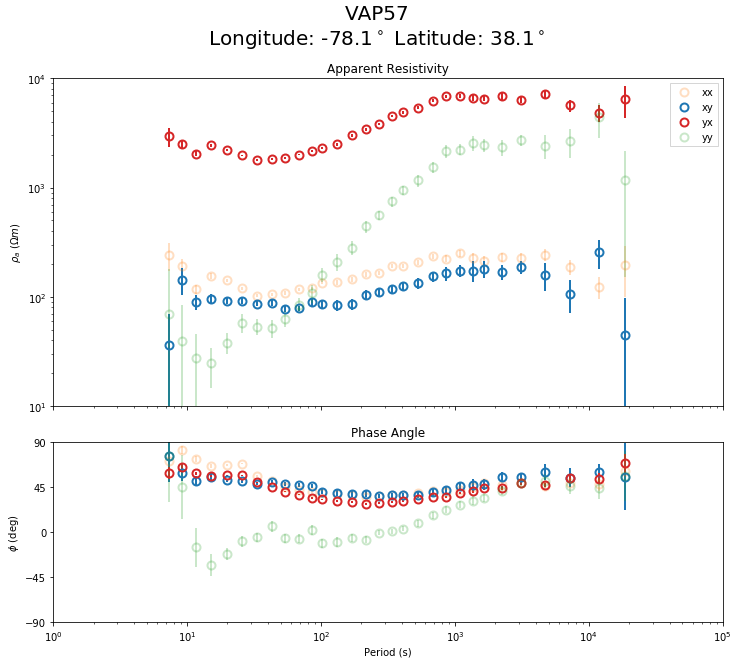

In [6]:
fig = site.plot_apparent_resistivity()

## Now look at what an interpolation through the data looks like

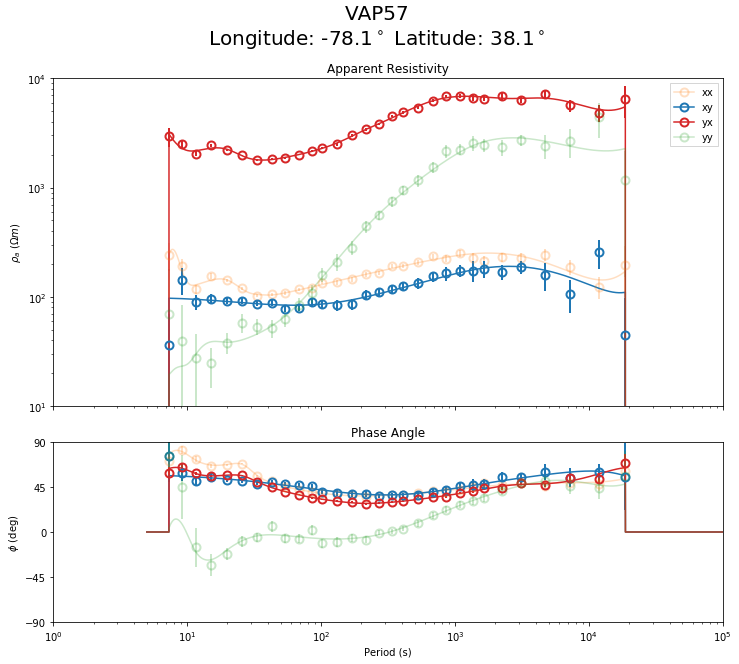

In [7]:
freqs = 1./np.logspace(np.log10(5), np.log10(1e5), 1e4)
fig = site.plot_apparent_resistivity(interp_freqs=freqs)

## Convolution with an artifical magnetic field

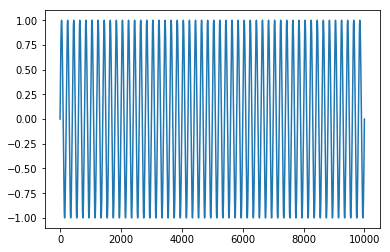

In [8]:
ts = np.arange(0, 10001)
# 200 second period
magX = np.sin(2*np.pi*ts/200)
magY = np.zeros(len(magX))
plt.plot(ts, magX)

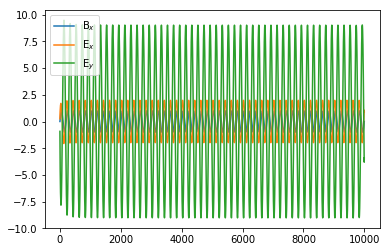

In [9]:
Ex, Ey = site.convolve_fft(magX, magY, dt=1)
plt.plot(ts, magX, label=r'B$_x$', c='C0')
plt.plot(ts, Ex, label=r'E$_x$', c='C1')
plt.plot(ts, Ey, label=r'E$_y$', c='C2')
plt.legend()

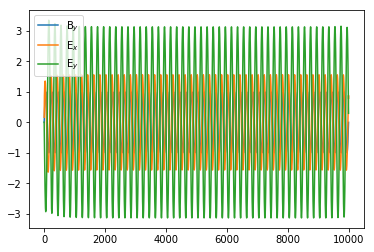

In [10]:
# Now flip the magX/magY
magX, magY = magY, magX
Ex, Ey = site.convolve_fft(magX, magY, dt=1)
plt.plot(ts, magY, label=r'B$_y$', c='C0')
plt.plot(ts, Ex, label=r'E$_x$', c='C1')
plt.plot(ts, Ey, label=r'E$_y$', c='C2')
plt.legend()

## Impulse Response

In [11]:
dtir = bezpy.mt.DTIR(nmin=-600, nmax=3600, dt=1,
                     decay_factor=1.e-12, model_space=True, verbose=True)
dtir

DTIR(dt=1, nmin=-600, nmax=3600, decay_factor=1e-12, Q_choice=1, model_space=True)

In [12]:
ns, zn = dtir.calculate(site=site)

Q Matrix Size: (4201, 4201)
Q Matrix Complete: 1.3506627082824707
Iteration 0  complete 2.2510199546813965
Iteration 1  complete 2.2285470962524414
Iteration 2  complete 2.2674200534820557
Iteration 3  complete 2.2311179637908936
Total time for impulse response: 10.3417489528656


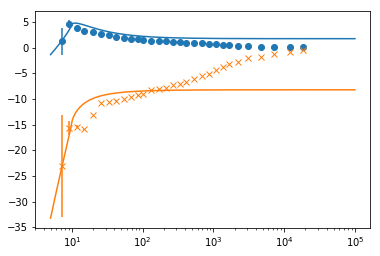

In [13]:
zf = dtir.get_zf(periods=1./freqs)
# Data
plt.errorbar(site.periods, site.Z[1,:].real, site.Z_var[1,:], c='C0', fmt='o', marker='o')
plt.errorbar(site.periods, site.Z[2,:].real, site.Z_var[2,:], c='C1', fmt='o', marker='x')
# DTIR
plt.semilogx(1./freqs, zf[1,:].real, c='C0')
plt.semilogx(1./freqs, zf[2,:].real, c='C1')

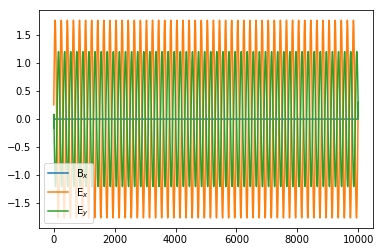

In [14]:
Ex, Ey = dtir.convolve(magX, magY)
plt.plot(ts, magX, label=r'B$_x$', c='C0')
plt.plot(ts, Ex, label=r'E$_x$', c='C1')
plt.plot(ts, Ey, label=r'E$_y$', c='C2')
plt.legend()

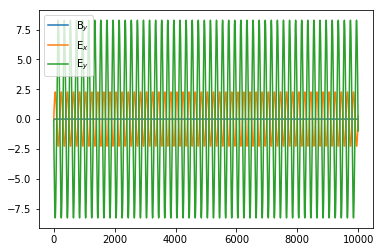

In [15]:
magX, magY = magY, magX
Ex, Ey = dtir.convolve(magX, magY)
plt.plot(ts, magY, label=r'B$_y$', c='C0')
plt.plot(ts, Ex, label=r'E$_x$', c='C1')
plt.plot(ts, Ey, label=r'E$_y$', c='C2')
plt.legend()